In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pickle
import random
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [5]:
path = 'data/'

with open(path + 'english_no_pad_sorted_50k.pickle', 'rb') as handle:
    english = pickle.load(handle)
    
with open(path + 'german_no_pad_sorted_50k.pickle', 'rb') as handle:
    german = pickle.load(handle)   

In [49]:
def average_sentence_size(german, desired_batch_size=128):
    summation = 0
    for i in german['train']:
        summation += len(i)
    avg_tok_sent = summation/len(german['train'])
    
    print("To get an average batch size of", desired_batch_size, "Use a batch_size value of:", int(desired_batch_size*avg_tok_sent))
    
average_sentence_size(german, desired_batch_size=80)

To get an average batch size of 80 Use a batch_size value of: 1657


In [20]:
def print_sentence(sent, language):
    if language == "german":
        for w in sent:
            print(german['idx2word'][w], end=' ')
    elif language == "english":
        for w in sent:
            print(english['idx2word'][w], end=' ')
    else:
        print("Language should be either 'german' or 'english'")
        
    print("")

In [7]:
torch.cuda.memory_allocated(device)

0

In [8]:
def get_batches(german, english, b_sz):
    batches = [[]]
    cur_batch = batches[-1]
    cur_batch_len = 0
        
    for i in range(len(german)):
        sent2sent = {"source": german[i],
                     "target": english[i]}
        
        if cur_batch_len + len(sent2sent['source']) < b_sz:
            cur_batch.append(sent2sent)
            cur_batch_len += len(sent2sent['source'])
        else:
            batches.append([])
            cur_batch = batches[-1]
            cur_batch_len = 0 
            cur_batch.append(sent2sent)
            cur_batch_len += len(sent2sent['source'])

            
    for idx, b in enumerate(batches):
        max_len_src = max([len(sent['source']) for sent in b])  
        max_len_trg = max([len(sent['target']) for sent in b])

        for sent in b:
            dif_src = max_len_src - len(sent['source'])
            dif_trg = max_len_trg - len(sent['target'])
            
            if dif_src > 0:
                pad_list_src = [0 for d in range(dif_src)]
                sent['source'].extend(pad_list_src)
                
            if dif_trg > 0:
                pad_list_trg = [0 for d in range(dif_trg)]
                sent['target'].extend(pad_list_trg)           
            
            sent['target'] = torch.tensor(sent['target']).cpu()
            sent['source'] = torch.tensor(sent['source']).cpu()

        
    return batches
t0 = time.time()
batches = get_batches(german['train'], english['train'], 2650)
print(time.time()-t0)

1.811434268951416


In [9]:
torch.cuda.memory_allocated(device)

0

In [8]:
random.shuffle(batches)
print(len(batches))
for i in range (5):
    print(len(batches[0]))

1550
45
45
45
45
45


In [11]:
def batchify(batch):
    source_sent_len = len(batch[0]['source'])
    target_sent_len = len(batch[0]['target'])
    
    batch_size = len(batch)
    
    source = torch.empty((source_sent_len, batch_size)).cpu()    
    target = torch.empty((target_sent_len, batch_size)).cpu()
    
    for i in range(len(batch)):
        source[:,i] = batch[i]['source']
        target[:,i] = batch[i]['target']
    
    
    return source, target

for b in batches:
    source, target = batchify(b)

# results = []
# for i in range(100):
#     if i%10==0: print(i)
#     random.shuffle(batches)

#     t2 = time.time()
#     for b in batches:
#         source, target = batchify(b)
#     results.append(time.time()-t2)

In [13]:
print(source)

tensor([[2.0000e+00, 2.0000e+00, 2.0000e+00,  ..., 2.0000e+00, 2.0000e+00,
         2.0000e+00],
        [3.0100e+02, 7.0000e+00, 6.1000e+01,  ..., 7.0000e+00, 3.3000e+01,
         1.0600e+02],
        [7.8400e+02, 8.0000e+00, 1.2000e+01,  ..., 8.0000e+00, 1.7820e+03,
         1.2000e+01],
        ...,
        [1.7900e+02, 1.1000e+01, 2.0700e+02,  ..., 4.3600e+02, 4.1160e+03,
         9.1282e+04],
        [3.0000e+00, 3.0000e+00, 3.0000e+00,  ..., 1.1000e+01, 1.1000e+01,
         1.1000e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.0000e+00, 3.0000e+00,
         3.0000e+00]], device='cuda:0')


### Results from building the tensors of the batches in the get_batches() function as .cpu() then using the tensors as input to batchify(), on the output of batchify() put them into .cuda()

In [10]:
print(sum(results)/len(results), "seconds/set of batches, on average")
print(min(results), max(results), "min and max times (seconds)")

print(torch.cuda.memory_allocated(device), "bytes allocated")
print(torch.cuda.memory_cached(device), "bytes cached")

2.291543083190918 seconds/set of batches, on average
2.2153544425964355 3.837550640106201 min and max times (seconds)
32768 bytes allocated
1048576 bytes cached


### Results from building the tensors in batchify(), as they are a list input for this function.

In [9]:
print(sum(results)/len(results), "seconds/set of batches, on average")
print(min(results), max(results), "min and max times (seconds)")

print(torch.cuda.memory_allocated(device), "bytes allocated")
print(torch.cuda.memory_cached(device), "bytes cached")

3.5291345620155337 seconds/set of batches, on average
3.422016143798828 5.263892889022827 min and max times (seconds)
25088 bytes allocated
1048576 bytes cached


# THE REASON THINGS ARE MESSED UP IS BECAUSE THE FUNCTION JUST KEEPS USING ALREADY WRITTEN DATA

## ONLY CALL GET_BATCHES() ONCE

# Another note: you might not need to put the batch on cuda at all, as it is just a tensor of indeces. Once the the batch goes through the embedding layer, it turns the indeces into embeddings

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pickle
import random
import time
from IPython.display import clear_output
import copy
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [9]:
path = 'data/'

with open(path + 'english_no_pad_sorted.pickle', 'rb') as handle:
    english = pickle.load(handle)
    
with open(path + 'german_no_pad_sorted.pickle', 'rb') as handle:
    german = pickle.load(handle)   

In [3]:
# MIN_LEN = 3
# MAX_LEN = 26
# COUNT = 30
# BUCKET_STEP = 3
# BATCH_SIZE = 40

# sentence_len = [random.randint(MIN_LEN, MAX_LEN) for i in range(COUNT)]
# # values = [i for i in range(MIN_LEN, MAX_LEN, BUCKET_STEP)]
# # buckets = [[] for i in values]

# print(len(sentence_len))
# print(buckets)

In [10]:
def to_padded_tensor(batch):
    max_len_src = max([len(sent['source']) for sent in batch])  
    max_len_trg = max([len(sent['target']) for sent in batch])

    for sent in batch:
        dif_src = max_len_src - len(sent['source'])
        dif_trg = max_len_trg - len(sent['target'])

        if dif_src > 0:
            pad_list_src = [0 for d in range(dif_src)]
            sent['source'].extend(pad_list_src)

        if dif_trg > 0:
            pad_list_trg = [0 for d in range(dif_trg)]
            sent['target'].extend(pad_list_trg)       
    
    source_sent_len = max_len_src
    target_sent_len = max_len_trg
    
    batch_size = len(batch)
    
    source = torch.empty((source_sent_len, batch_size)).long().cpu()    
    target = torch.empty((target_sent_len, batch_size)).long().cpu()
    
#     print(batch[0]['target'])
    
    for i in range(len(batch)):
        source[:,i] = torch.tensor(batch[i]['source'])
        target[:,i] = torch.tensor(batch[i]['target'])
        
    padded_tensor = {"source": source.to(device),
                    "target": target.to(device)}
    
    return padded_tensor

In [11]:
def bake_batches(de, en, batch_size=1300, min_len=3, max_len=768, bucket_step=3):
    german = copy.deepcopy(de)
    english = copy.deepcopy(en)
    
    buckets = [[] for i in range(0, max_len, bucket_step)]
    bucket_lengths = [0 for i in buckets]
    batches = []
    
    # For every sentence in the dataset, find its corresponding bucket and put it in there, once the bucket
    # hits the batch size, ship it off to the batches list
    for i in range(len(german)):
        sent2sent = {"source": german[i],
                     "target": english[i]}
        
        # calculate the index of the buckets to put the sentence into, = len(Sentence) // Bucket_step - 1
        idx = len(sent2sent['source'])//bucket_step - 1
        
        if bucket_lengths[idx] + len(sent2sent['source']) > batch_size:
            batches.append(to_padded_tensor(buckets[idx][:]))
            del buckets[idx][:]
            buckets[idx].append(sent2sent)
            bucket_lengths[idx] = len(sent2sent['source'])
        else:
            buckets[idx].append(sent2sent)
            bucket_lengths[idx] += len(sent2sent['source'])
            

    # for any remaining buckets that did not get sent off, send them off to batches
    for b in buckets:
        if b: # if the list has any value in it
            batches.append(to_padded_tensor(b[:]))
            del b[:]
    
    return batches

In [50]:
# for b in buckets:
#     if b:
#         print(b)
batches = bake_batches(german['train'], english['train'], batch_size=1600)
print("number of batches:", len(batches))


total = 0
for b in batches:
    total += b['source'].shape[1]
print("Total sentences, should be 196,884):",total)
# batches[0]

2623
196884


In [54]:
batches[0]['source'].shape

torch.Size([4, 404])

In [51]:
source_tensor_size = []
target_tensor_size = []
combined_tensor_size = []

for b in batches:
    src_size = b['source'].shape[0] * b['source'].shape[1]
    trg_size = b['target'].shape[0] * b['target'].shape[1]
    
    source_tensor_size.append(src_size)
    target_tensor_size.append(trg_size)
    combined_tensor_size.append(src_size + trg_size)

## BATCH SIZE

### Batch sizes can have a large impact on how much GPU memory is being used at once and also affects the way the model trains.

### Typically, the larger the batch size, the more 'smooth' the loss curve will be, but this comes at the cost of using a lot of GPU memory, so we will want to find the goldi-locks batch size that balances between performance and memory usage.

Text(0,0.5,'Total Batch Size (L length x N sentences)')

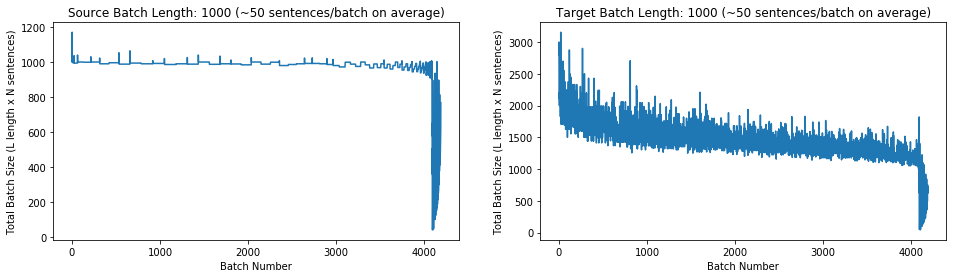

In [48]:
x = np.arange(0, len(source_tensor_size), 1)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(x, source_tensor_size)
plt.title("Source Batch Length: 1000 (~50 sentences/batch on average)")
plt.xlabel("Batch Number")
plt.ylabel("Total Batch Size (L length x N sentences)")
plt.subplot(122)
plt.plot(x, target_tensor_size)
plt.title("Target Batch Length: 1000 (~50 sentences/batch on average)")
plt.xlabel("Batch Number")
plt.ylabel("Total Batch Size (L length x N sentences)")


Text(0,0.5,'Total Batch Size (L length x N sentences)')

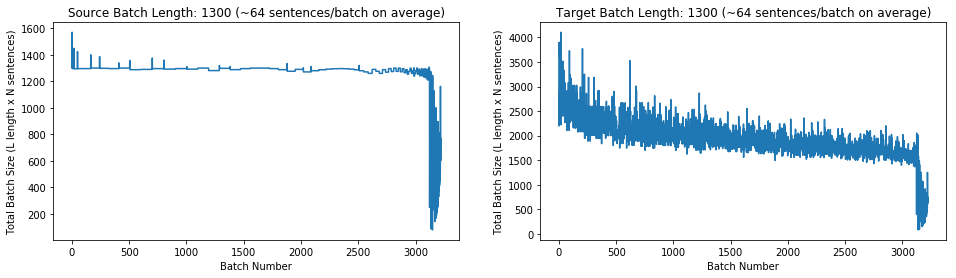

In [42]:
x = np.arange(0, len(source_tensor_size), 1)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(x, source_tensor_size)
plt.title("Source Batch Length: 1300 (~64 sentences/batch on average)")
plt.xlabel("Batch Number")
plt.ylabel("Total Batch Size (L length x N sentences)")
plt.subplot(122)
plt.plot(x, target_tensor_size)
plt.title("Target Batch Length: 1300 (~64 sentences/batch on average)")
plt.xlabel("Batch Number")
plt.ylabel("Total Batch Size (L length x N sentences)")


Text(0,0.5,'Total Batch Size (L length x N sentences)')

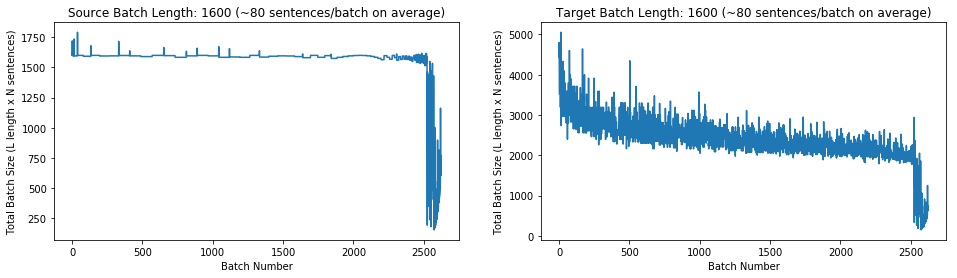

In [52]:
x = np.arange(0, len(source_tensor_size), 1)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(x, source_tensor_size)
plt.title("Source Batch Length: 1600 (~80 sentences/batch on average)")
plt.xlabel("Batch Number")
plt.ylabel("Total Batch Size (L length x N sentences)")
plt.subplot(122)
plt.plot(x, target_tensor_size)
plt.title("Target Batch Length: 1600 (~80 sentences/batch on average)")
plt.xlabel("Batch Number")
plt.ylabel("Total Batch Size (L length x N sentences)")

Text(0,0.5,'Total Batch Size (L length x N sentences)')

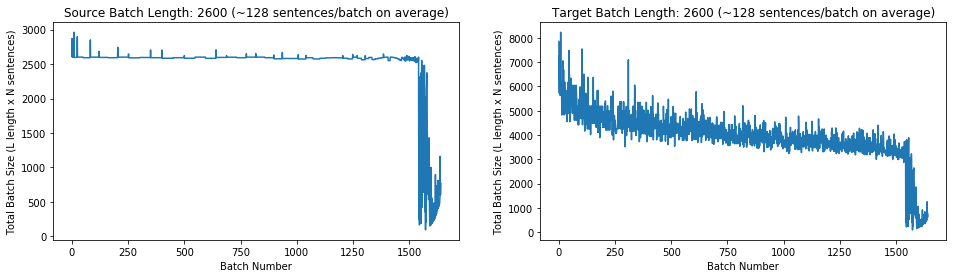

In [39]:
x = np.arange(0, len(source_tensor_size), 1)

plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(x, source_tensor_size)
plt.title("Source Batch Length: 2600 (~128 sentences/batch on average)")
plt.xlabel("Batch Number")
plt.ylabel("Total Batch Size (L length x N sentences)")
plt.subplot(122)
plt.plot(x, target_tensor_size)
plt.title("Target Batch Length: 2600 (~128 sentences/batch on average)")
plt.xlabel("Batch Number")
plt.ylabel("Total Batch Size (L length x N sentences)")


In [162]:
print_sentence(batches[11][1]['source'], 'german')
print_sentence(batches[11][1]['target'], 'english')

<sos> erstaunliche antennen . <eos> 
<sos> we have amazing antennae . <eos> 


In [5]:
print(english['train'][0])

[2, 9642, 40, 3]


In [7]:
# def add_zero(sentence):
#     sentence = sentence.copy()
#     sentence.append(0)
    
# print(german['train'][232])
# add_zero(german['train'][232])
# print(german['train'][232])


In [6]:
training_data = [[german['train'][i], english['train'][i]] for i in range(50)]

In [26]:
random.shuffle(training_data)
training_data[0]

[[2, 735, 3541, 14, 3], [2, 710, 717, 40, 3]]

In [30]:
print_sentence([2, 304, 8280, 14, 3], 'german')
print_sentence([2, 23, 6385, 40, 3], 'english')

<sos> man überkompensiert . <eos> 
<sos> you overcompensate . <eos> 


In [28]:
de_shuffled = [td[0] for td in training_data]
en_shuffled = [td[1] for td in training_data]

In [29]:
print(de_shuffled[32], en_shuffled[32])

[2, 304, 8280, 14, 3] [2, 23, 6385, 40, 3]


Example training loop

In [35]:
training_data = [[german['train'][i], english['train'][i]] for i in range(50)]
for i in range(20):
    random.shuffle(training_data)

    de_shuffled = [td[0] for td in training_data]
    en_shuffled = [td[1] for td in training_data]
    
    batches = bake_batches(de_shuffled, en_shuffled, batch_size=20, max_len=20)
    total = 0
    for b in batches:
        total += b['source'].shape[0]
        total += b['source'].shape[1]
    print(total)


115
115
115
115
115
115
114
115
115
115
115
115
115
115
115
115
115
114
114
115


In [14]:
for i in range(3, 9, 3):
    print(i)

3
6
